# Project Name : PERSONALIZED CANCER DIAGNOSIS

<h2>This is an multi class classification problem we need to determine the Class label by using features like Gene,Variant
and text(research of bio medical) , we need to find out the class label based on the features provided.</h2>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


C:\Users\anudeep\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [8]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 53.74644928700218 seconds


In [9]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [11]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [12]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [13]:
y_true = result['Class']
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.33,random_state=45)


In [14]:
X_train.shape

(2225, 5)

Distribution of yi's

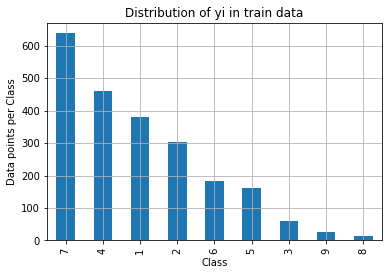

Number of data points in class 1 : 638 ( 28.674 %)
Number of data points in class 2 : 460 ( 20.674 %)
Number of data points in class 3 : 380 ( 17.079 %)
Number of data points in class 4 : 303 ( 13.618 %)
Number of data points in class 5 : 184 ( 8.27 %)
Number of data points in class 6 : 162 ( 7.281 %)
Number of data points in class 7 : 60 ( 2.697 %)
Number of data points in class 8 : 25 ( 1.124 %)
Number of data points in class 9 : 13 ( 0.584 %)
--------------------------------------------------------------------------------


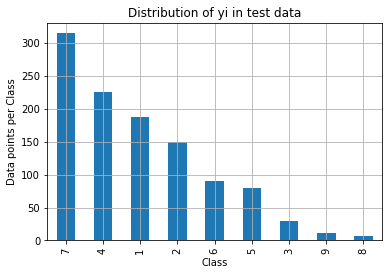

Number of data points in class 1 : 315 ( 28.741 %)
Number of data points in class 2 : 226 ( 20.62 %)
Number of data points in class 3 : 188 ( 17.153 %)
Number of data points in class 4 : 149 ( 13.595 %)
Number of data points in class 5 : 91 ( 8.303 %)
Number of data points in class 6 : 80 ( 7.299 %)
Number of data points in class 7 : 29 ( 2.646 %)
Number of data points in class 8 : 12 ( 1.095 %)
Number of data points in class 9 : 6 ( 0.547 %)


In [15]:
train_class_distribution = y_train.value_counts()
test_class_distribution = y_test.value_counts()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')


# Univariate Analysis - GENE Feature

In [16]:
unique_genes = X_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 237
BRCA1     181
TP53      104
PTEN       87
EGFR       86
BRCA2      72
KIT        69
BRAF       60
ERBB2      47
PDGFRA     44
ALK        42
Name: Gene, dtype: int64


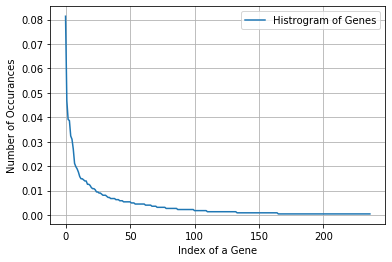

In [17]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

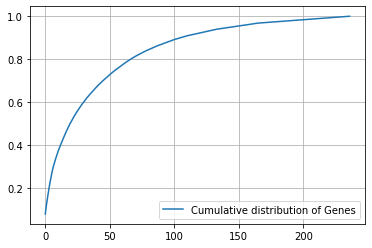

In [18]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

# Feature engineering (MEAN ENCODING) on GENE Feature

In [19]:
X_train.groupby(['Gene'])['Class'].mean()

Gene
ABL1       2.500000
ACVR1      4.500000
AGO2       1.500000
AKT1       5.842105
AKT2       7.400000
             ...   
WHSC1      7.000000
WHSC1L1    6.000000
XPO1       4.000000
XRCC2      1.000000
YAP1       3.250000
Name: Class, Length: 237, dtype: float64

In [20]:
ordered_labels = X_train.groupby(['Gene'])['Class'].mean().to_dict()
ordered_labels

{'ABL1': 2.5,
 'ACVR1': 4.5,
 'AGO2': 1.5,
 'AKT1': 5.842105263157895,
 'AKT2': 7.4,
 'AKT3': 5.333333333333333,
 'ALK': 5.380952380952381,
 'APC': 2.2,
 'AR': 5.6,
 'ARAF': 7.0,
 'ARID1A': 1.0,
 'ARID1B': 1.0,
 'ARID2': 1.0,
 'ARID5B': 1.0,
 'ASXL2': 1.0,
 'ATM': 2.5,
 'ATRX': 1.0,
 'AURKA': 5.5,
 'AURKB': 2.0,
 'AXIN1': 1.0,
 'AXL': 2.0,
 'B2M': 2.0,
 'BAP1': 2.8,
 'BARD1': 1.0,
 'BCL10': 1.0,
 'BCL2': 7.0,
 'BCOR': 6.25,
 'BRAF': 4.983333333333333,
 'BRCA1': 3.9447513812154695,
 'BRCA2': 5.111111111111111,
 'BRIP1': 3.2,
 'BTK': 5.5,
 'CARD11': 6.0,
 'CASP8': 3.2,
 'CBL': 3.857142857142857,
 'CCND1': 7.0,
 'CCND2': 2.0,
 'CCND3': 3.25,
 'CCNE1': 7.0,
 'CDH1': 2.5,
 'CDK12': 2.875,
 'CDK4': 7.0,
 'CDK6': 4.0,
 'CDKN1A': 2.6666666666666665,
 'CDKN1B': 4.0,
 'CDKN2A': 3.806451612903226,
 'CDKN2B': 3.5,
 'CDKN2C': 1.0,
 'CEBPA': 1.0,
 'CHEK2': 4.2,
 'CIC': 3.6666666666666665,
 'CREBBP': 2.1666666666666665,
 'CTCF': 3.6666666666666665,
 'CTLA4': 1.0,
 'CTNNB1': 6.583333333333333,
 'DDR2'

In [21]:
X_train['Gene_fe'] = X_train.Gene.map(ordered_labels)
X_test['Gene_fe'] = X_test.Gene.map(ordered_labels)

In [22]:
X_train.head()

,ID,Gene,Variation,Class,TEXT,Gene_fe
1934,1934,CARD11,C49Y,7,three new benta patients sharing novel autosom...,6.000000
2518,2518,BRCA1,M1775K,4,abstract brca1 gene individuals risk breast ov...,3.944751
415,415,TP53,L330R,1,tumor suppressor protein p53 transcription fac...,2.644231
864,864,ERG,TMPRSS2-ERG_Fusion,7,tmprss2 erg gene fusions occur 50 prostate can...,5.333333
3212,3212,RB1,Truncating_Mutations,1,retinoblastoma pediatric tumor developing reti...,3.250000


In [23]:
X_test['Gene_fe'].fillna(X_train['Gene_fe'].mean(),inplace=True)

For values of alpha =  1e-05 The log loss is: 1.5461885153198667
For values of alpha =  0.0001 The log loss is: 1.5461885129114294
For values of alpha =  0.001 The log loss is: 1.5461885105279347
For values of alpha =  0.01 The log loss is: 1.54618851444098
For values of alpha =  0.1 The log loss is: 1.5461885136008062
For values of alpha =  1 The log loss is: 1.546188518377175


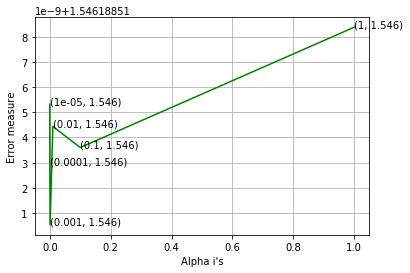

For values of best alpha =  0.001 The train log loss is: 1.4981381992189313
For values of best alpha =  0.001 The test log loss is: 1.5461885105279347


In [24]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train[['Gene_fe']], y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train[['Gene_fe']], y_train)
    predict_y = sig_clf.predict_proba(X_test[['Gene_fe']])
    cv_log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train[['Gene_fe']], y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train[['Gene_fe']], y_train)

predict_y = sig_clf.predict_proba(X_train[['Gene_fe']])
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test[['Gene_fe']])
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# UNIVARIATE ANALYSIS on Variation Feature

In [25]:
unique_variations = X_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 2017
Truncating_Mutations    66
Deletion                55
Amplification           45
Fusions                 19
Overexpression           4
Q61R                     3
G12V                     3
Q61L                     3
T286A                    2
K117N                    2
Name: Variation, dtype: int64


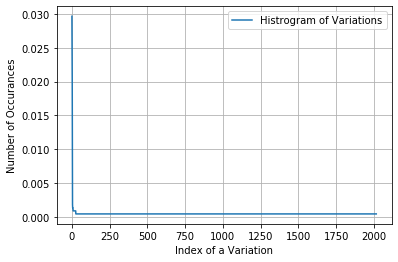

In [26]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

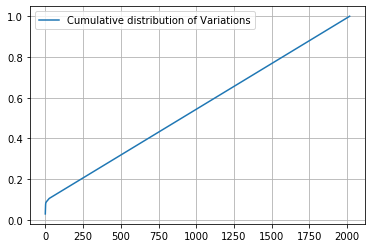

In [27]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

# Feature engineering (ONE HOT ENCODING) on Variation Feature

In [28]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])

For values of alpha =  1e-05 The log loss is: 1.7227702509296232
For values of alpha =  0.0001 The log loss is: 1.7149261445433195
For values of alpha =  0.001 The log loss is: 1.7129433052778362
For values of alpha =  0.01 The log loss is: 1.72415501028724
For values of alpha =  0.1 The log loss is: 1.7346306327294252
For values of alpha =  1 The log loss is: 1.7364049041791751


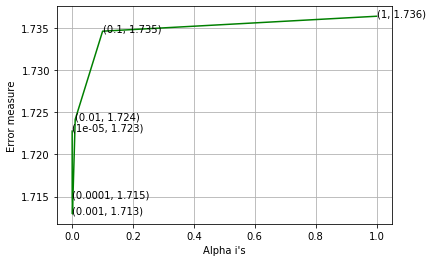

For values of best alpha =  0.001 The train log loss is: 1.0379805839121237
For values of best alpha =  0.001 The test log loss is: 1.7129433052778362


In [29]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# UNIVARIATE ANALYSIS ON TEXT FEATURE

In [30]:
Text_vectorizer=TfidfVectorizer(ngram_range=(1,3),min_df=5,max_features=300000)
tfidf_train_text=Text_vectorizer.fit_transform(X_train['TEXT'])
tfidf_test_text=Text_vectorizer.transform(X_test['TEXT'])

For values of alpha =  1e-05 The log loss is: 1.0307703816810783
For values of alpha =  0.0001 The log loss is: 0.9883942744234622
For values of alpha =  0.001 The log loss is: 1.0594763823810922
For values of alpha =  0.01 The log loss is: 1.2401935345261066
For values of alpha =  0.1 The log loss is: 1.4644012156940187
For values of alpha =  1 The log loss is: 1.5408836896698683


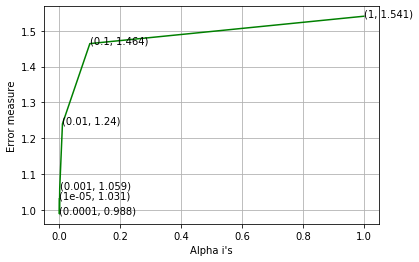

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                          

In [31]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_train_text, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train_text, y_train)
    predict_y = sig_clf.predict_proba(tfidf_test_text)
    cv_log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_train_text, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train_text, y_train)

In [32]:
predict_y = sig_clf.predict_proba(tfidf_train_text)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test_text)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.6409132586647615
For values of best alpha =  0.0001 The test log loss is: 0.9883942744234622


In [33]:
X_train1=hstack((X_train[['Gene_fe']].values,train_variation_feature_onehotCoding,tfidf_train_text)).tocsr()
X_test1=hstack((X_test[['Gene_fe']].values,test_variation_feature_onehotCoding,tfidf_test_text)).tocsr()

In [34]:
X_train1

<2225x302042 sparse matrix of type '<class 'numpy.float64'>'
	with 11746135 stored elements in Compressed Sparse Row format>

# MACHINE LEARNING MODELS

1)Naive Bayes Model

for alpha = 1e-05
Log Loss : 1.1870677527785705
for alpha = 0.0001
Log Loss : 1.183526898008643
for alpha = 0.001
Log Loss : 1.1814890178990674
for alpha = 0.1
Log Loss : 1.318490153055532
for alpha = 1
Log Loss : 1.4588435285884038
for alpha = 10
Log Loss : 1.4970329118217345
for alpha = 100
Log Loss : 1.59939856951854
for alpha = 1000
Log Loss : 1.5861548000619972


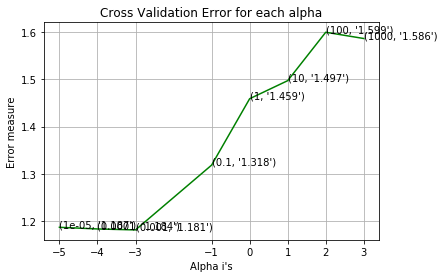

For values of best alpha =  0.001 The train log loss is: 0.8004438686892175
For values of best alpha =  0.001 The test log loss is: 1.1814890178990674
Number of missclassified point : 0.354014598540146


In [32]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_test1)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train)


predict_y = sig_clf.predict_proba(X_train1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_test1)- y_test))/y_test.shape[0])


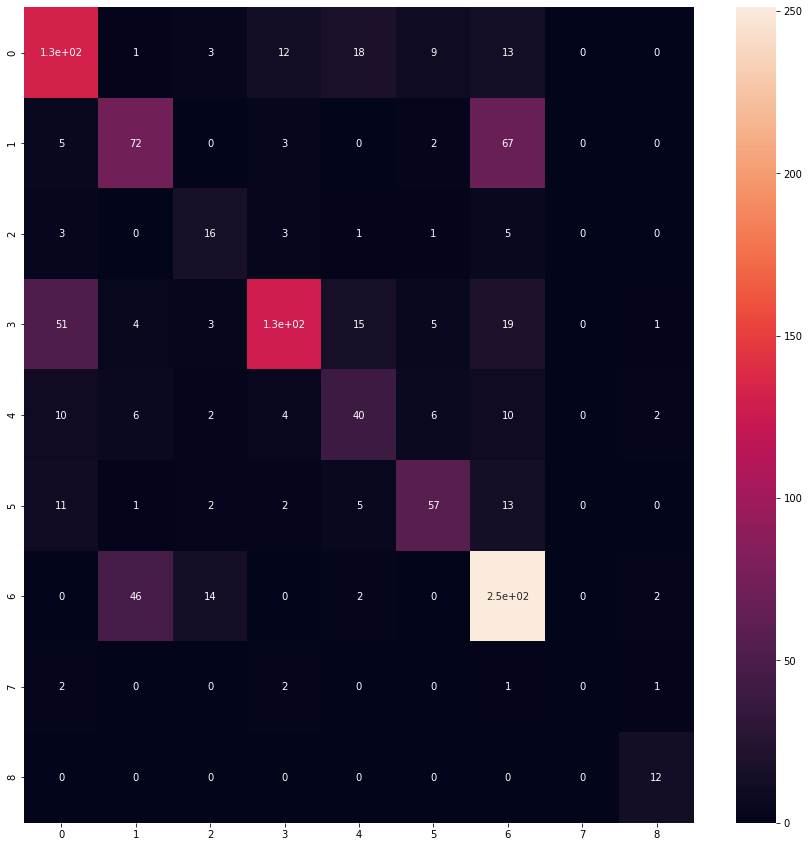

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,15))
cm=confusion_matrix(y_test,sig_clf.predict(X_test1))
sns.heatmap(cm,annot=True)

<h2>LOGISTIC REGRESSION</h2>

<h3>1) with class balancing</h3>

for alpha = 1e-06
Log Loss : 0.9882084981422289
for alpha = 1e-05
Log Loss : 0.9912652132293273
for alpha = 0.0001
Log Loss : 0.9671535700399553
for alpha = 0.001
Log Loss : 1.0368572935475893
for alpha = 0.01
Log Loss : 1.494065301476834
for alpha = 0.1
Log Loss : 1.5539993399951653
for alpha = 1
Log Loss : 1.5472052271564631
for alpha = 10
Log Loss : 1.5465431108391725
for alpha = 100
Log Loss : 1.5464686791025952


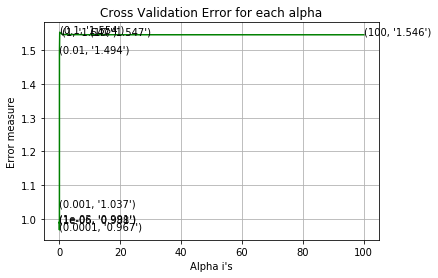

For values of best alpha =  0.0001 The train log loss is: 0.4082013140437994
For values of best alpha =  0.0001 The test log loss is: 0.9671535700399553
Number of missclassified point : 0.33211678832116787


In [34]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_test1)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train)

predict_y = sig_clf.predict_proba(X_train1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_test1)- y_test))/y_test.shape[0])

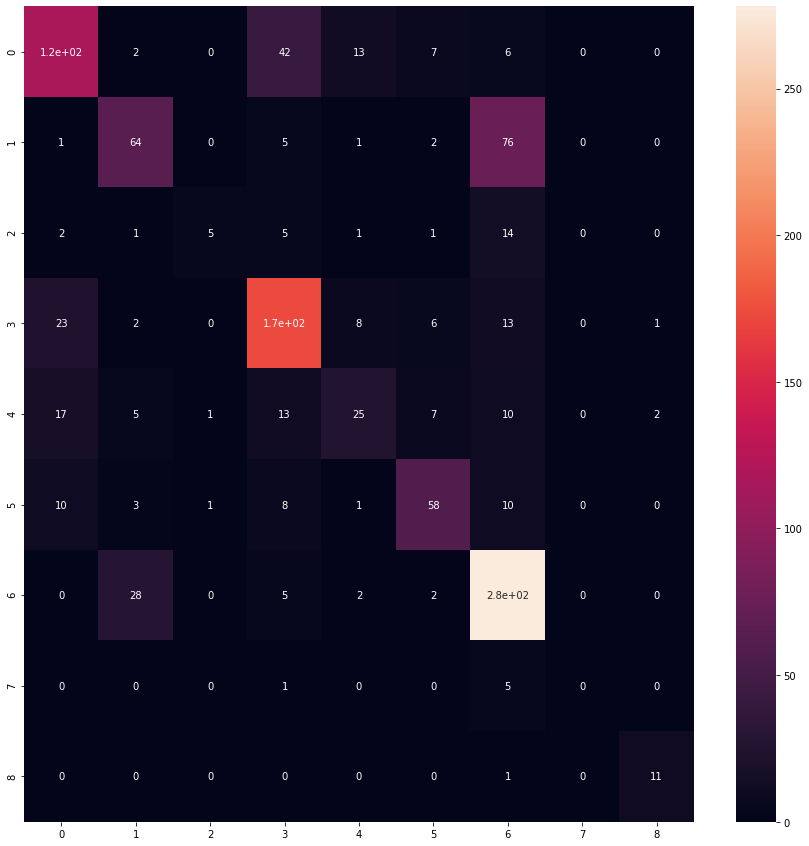

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,15))
cm=confusion_matrix(y_test,sig_clf.predict(X_test1))
sns.heatmap(cm,annot=True)

<h3>2) without Balancing</h3>

for alpha = 1e-06
Log Loss : 0.990047303356213
for alpha = 1e-05
Log Loss : 0.9890396800006194
for alpha = 0.0001
Log Loss : 0.9852210621032089
for alpha = 0.001
Log Loss : 1.0792283534563905
for alpha = 0.01
Log Loss : 1.3212661603057811
for alpha = 0.1
Log Loss : 1.5977403342617291
for alpha = 1
Log Loss : 1.5516249671390288


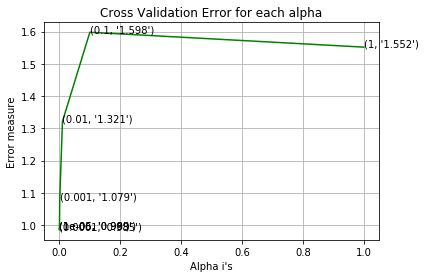

For values of best alpha =  0.0001 The train log loss is: 0.4194262328948337
For values of best alpha =  0.0001 The test log loss is: 0.9852210621032089
Number of missclassified point : 0.33485401459854014


In [36]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_test1)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train)

predict_y = sig_clf.predict_proba(X_train1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_test1)- y_test))/y_test.shape[0])

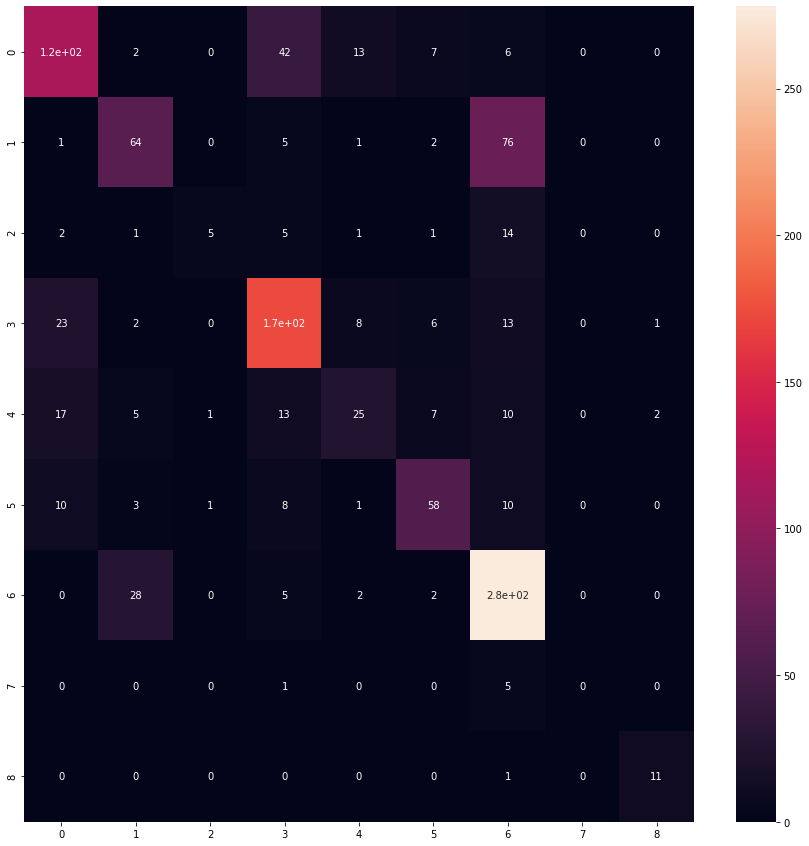

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,15))
cm=confusion_matrix(y_test,sig_clf.predict(X_test1))
sns.heatmap(cm,annot=True)

<h2>Linear Support Vector Machine</h2>

for C = 1e-05
Log Loss : 0.9895808438975547
for C = 0.0001
Log Loss : 0.977805025105816
for C = 0.001
Log Loss : 1.0023519966948224
for C = 0.01
Log Loss : 1.280909116259197
for C = 0.1
Log Loss : 1.5418804962466635
for C = 1
Log Loss : 1.5454668365098123
for C = 10
Log Loss : 1.5464575102430471
for C = 100
Log Loss : 1.54645996790748


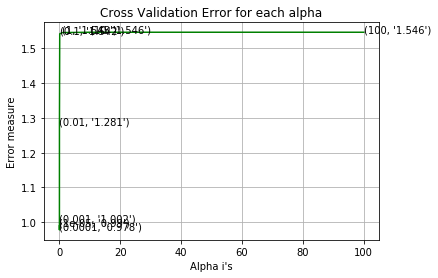

For values of best alpha =  0.0001 The train log loss is: 0.37397447039795123
For values of best alpha =  0.0001 The test log loss is: 0.977805025105816
Number of missclassified point : 0.3385036496350365


In [35]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_test1)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train)

predict_y = sig_clf.predict_proba(X_train1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_test1)- y_test))/y_test.shape[0])

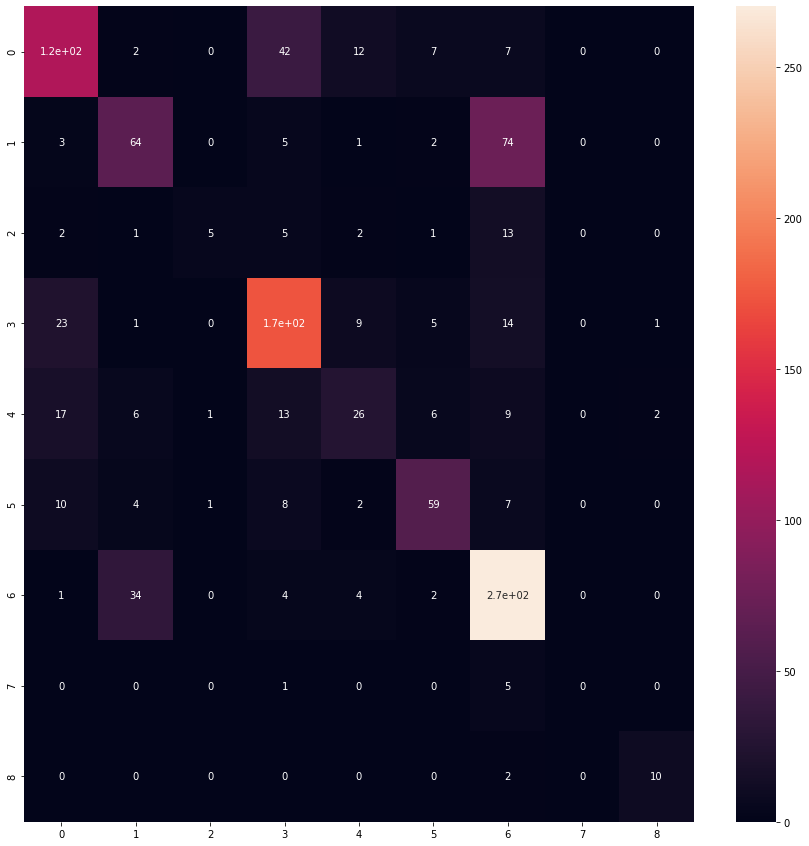

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,15))
cm=confusion_matrix(y_test,sig_clf.predict(X_test1))
sns.heatmap(cm,annot=True)

<h2>Random Forest Classifier</h2>

In [32]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"max_depth":[5,10,50],
              "n_estimators":[100,200,300,400,500]}

model = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,cv=3,n_jobs=-1)

model.fit(X_train1,y_train)
model.best_params_

{'n_estimators': 300, 'max_depth': 50}

In [37]:
clf=RandomForestClassifier(n_jobs=-1,random_state=25,max_depth=50,n_estimators=300)
clf.fit(X_train1,y_train)
y_pred_test=clf.predict_proba(X_test1)
y_pred_train=clf.predict_proba(X_train1)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)

Train log loss =  0.2101869047964812  Test log loss =  1.1302275743538654


In [38]:
print("Number of missclassified point :", np.count_nonzero((clf.predict(X_test1)- y_test))/y_test.shape[0])

Number of missclassified point : 0.3458029197080292


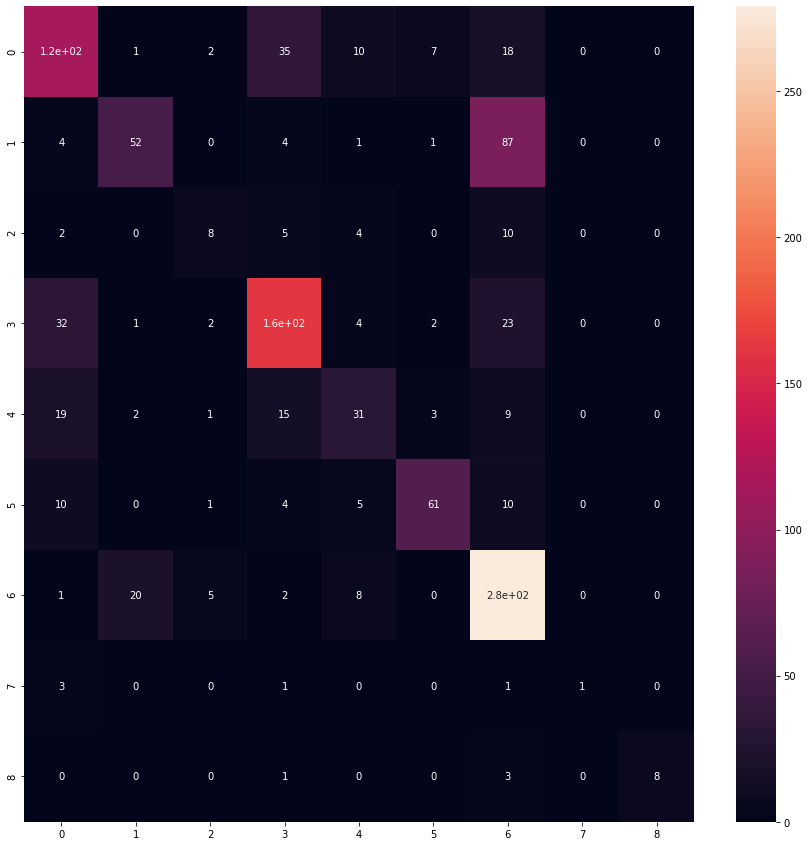

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,15))
cm=confusion_matrix(y_test,clf.predict(X_test1))
sns.heatmap(cm,annot=True)

<h3>Overview of all models</h3>

In [39]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","log loss","Mis Classified points"]
x.add_row(['Naive Bayes','1.181','0.354'])
x.add_row(['Logistic regression(without Balancing)','0.985','0.334'])
x.add_row(['Logistic regression(with Balancing)','0.967','0.332'])
x.add_row(['Linear SVM','0.977','0.338'])
x.add_row(['Random Forest Classifier','1.130','0.345'])

print(x)

+----------------------------------------+----------+-----------------------+
|                 Model                  | log loss | Mis Classified points |
+----------------------------------------+----------+-----------------------+
|              Naive Bayes               |  1.181   |         0.354         |
| Logistic regression(without Balancing) |  0.985   |         0.334         |
|  Logistic regression(with Balancing)   |  0.967   |         0.332         |
|               Linear SVM               |  0.977   |         0.338         |
|        Random Forest Classifier        |  1.130   |         0.345         |
+----------------------------------------+----------+-----------------------+
